# Non Stationary LSTM

주가처럼 그래프 자체만으로는 random walk수준의 그래프 이지만, 외부변수를 줌으로서 LSTM이 어떻게 예측을 할 수 있는지 테스트

In [16]:
%pylab inline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.activations import relu
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


## Data

data x shape: (10000, 50, 5)
data y shape: (10000, 50, 1)


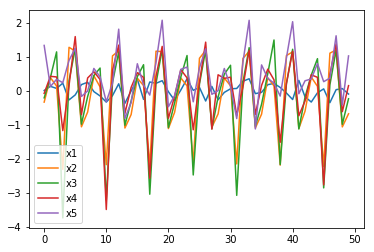

In [11]:
BATCH_SIZE=10000
TIME_SERIES_LENGTH = 50
OUTSIDE_VAR_COUNT = 5

# 요일 이펙트
def d1(x):
    return 1/(np.e * (x+0.023))

def d2(x):
    return -1/(x+0.02)

def d3(x):
    return 1/(x + 1.7)

def d4(x):
    return 2

def d5(x):
    return -1

def create_data(batch_size=1000, time_series_length=500, moving_avg_n=1):
    funcs = [np.sin, np.cos, d1, d2, d3, d4, d5]
    func_count = len(funcs)
    var_count = 5
    
    x_data = np.zeros((batch_size, time_series_length, var_count))
    y_data = np.zeros((batch_size, time_series_length, 1))

    for batch_idx in range(batch_size):
        ts_x = np.zeros((time_series_length, var_count), dtype=np.float16)
        ts_y = np.zeros((time_series_length, 1))
        
        y1_prev, y2_prev, y3_prev, y4_prev, y5_prev = (0, 0, 0, 0, 0)
        
        t = 0
        while t < time_series_length:
            x1 = np.random.rand(1)
            x2 = np.random.rand(1) * 0.1
            x3 = np.random.rand(1) * 0.2
            x4 = np.random.rand(1) * 0.7
            x5 = np.random.rand(1) * 1.5
            
            ts_x[t, 0] = x1
            ts_x[t, 1] = funcs[t%func_count](x2 + y2_prev * 0.5) + x2
            ts_x[t, 2] = funcs[t%func_count](x3 + y3_prev * 0.1) + x3
            ts_x[t, 3] = funcs[t%func_count](x4 + y4_prev * 0.2) + x4
            ts_x[t, 4] = funcs[t%func_count](x5 + y5_prev * 0.4) + x5
            ts_y[t, 0] = funcs[t%func_count](x1 + y1_prev * 0.3) + x1
            y1_prev, y2_prev, y3_prev, y4_prev, y5_prev = ts_x[t].tolist()
            
            if np.isinf(ts_x[t]).any():
                continue
            t += 1
            
        x_data[batch_idx, :] = ts_x
        y_data[batch_idx, :] = ts_y
    return x_data, y_data
    
data_x, data_y = create_data(batch_size=BATCH_SIZE, 
                             time_series_length=TIME_SERIES_LENGTH)


# Scaling X
x_shape = data_x.shape
scaler_x = StandardScaler()
data_x = scaler_x.fit_transform(data_x.reshape(-1, 1))
data_x = data_x.reshape(x_shape)

plot(data_x[0, :, 0], label='x1')
plot(data_x[0, :, 1], label='x2')
plot(data_x[0, :, 2], label='x3')
plot(data_x[0, :, 3], label='x4')
plot(data_x[0, :, 4], label='x5')
legend()

# Scaling Y
y_shape = data_y.shape
scaler_y = StandardScaler()
data_y = scaler_y.fit_transform(data_y.reshape(-1, 1))
data_y = data_y.reshape(y_shape)

print('data x shape:', data_x.shape)
print('data y shape:', data_y.shape)
# plot(data_y[0], label='y')

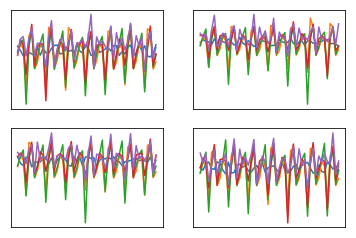

In [12]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
                        
            batch_idx = np.random.randint(data_x.shape[0])
            sample_x = data_x[batch_idx]
#             sample_y = data_y[batch_idx]
                                    
            sample_x1 = sample_x[:, 0]
            sample_x2 = sample_x[:, 1]
            sample_x3 = sample_x[:, 2]
            sample_x4 = sample_x[:, 3]
            sample_x5 = sample_x[:, 4]
        
            tick_x = range(sample_x.shape[0])
            
            sp.plot(tick_x, sample_x1, label='x1')
            sp.plot(tick_x, sample_x2, label='x2')
            sp.plot(tick_x, sample_x3, label='x3')
            sp.plot(tick_x, sample_x4, label='x4')
            sp.plot(tick_x, sample_x5, label='x5')
            
visualize(data_x, data_y)

## Model

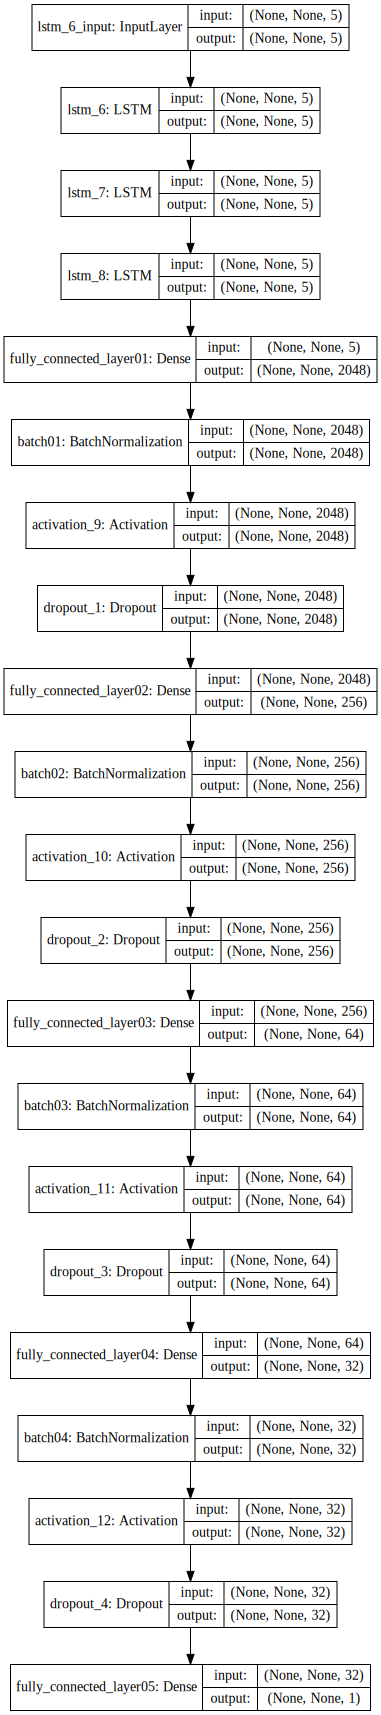

In [17]:
def create_model(lstm_out1=5, lstm_out2=5, lstm_out3=5, dense1=2048, dense2=256, dense3=64, dense4=32, 
                 optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(LSTM(lstm_out1, batch_input_shape=(None, None, OUTSIDE_VAR_COUNT), return_sequences=True))
    if lstm_out2 is not None:
        model.add(LSTM(lstm_out2, return_sequences=True))
    
    if lstm_out3 is not None:
        model.add(LSTM(lstm_out3, return_sequences=True))
    
    model.add(Dense(dense1, name='fully_connected_layer01'))
    model.add(BatchNormalization(name='batch01'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(dense2, name='fully_connected_layer02'))
    model.add(BatchNormalization(name='batch02'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(dense3, name='fully_connected_layer03'))
    model.add(BatchNormalization(name='batch03'))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(dense4, name='fully_connected_layer04'))
    model.add(BatchNormalization(name='batch04'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, name='fully_connected_layer05'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mean_squared_error])
    return model
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training

In [14]:
model = create_model(lstm_out1=150, lstm_out2=100, lstm_out3=None, dense1=2048, dense2=1024, dense3=512, dense4=128)
model.fit(data_x, data_y, verbose=2, epochs=3000)

Epoch 1/3000
30s - loss: 0.2122 - mean_squared_error: 0.2122
Epoch 2/3000
30s - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 3/3000
30s - loss: 0.0409 - mean_squared_error: 0.0409
Epoch 4/3000
29s - loss: 0.0368 - mean_squared_error: 0.0368
Epoch 5/3000
29s - loss: 0.0321 - mean_squared_error: 0.0321
Epoch 6/3000
29s - loss: 0.0301 - mean_squared_error: 0.0301
Epoch 7/3000
29s - loss: 0.0288 - mean_squared_error: 0.0288
Epoch 8/3000
29s - loss: 0.0235 - mean_squared_error: 0.0235
Epoch 9/3000
29s - loss: 0.0252 - mean_squared_error: 0.0252
Epoch 10/3000
29s - loss: 0.0258 - mean_squared_error: 0.0258
Epoch 11/3000
29s - loss: 0.0253 - mean_squared_error: 0.0253
Epoch 12/3000
29s - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 13/3000
29s - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 14/3000
29s - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 15/3000
30s - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 16/3000
29s - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 17/3000
30s

KeyboardInterrupt: 

error:3.4501134957106636, score:-2.4501134957106645
score: -2.45011349571


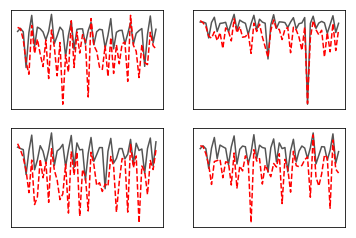

In [15]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


def visualize_prediction(data_x, data_y):
    pred_y = model.predict(data_x)
    
    print('score:', accuracy(data_y, pred_y))
    
    fig, sub_plots = subplots(2, 2)
    
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            idx = np.random.randint(data_x.shape[0])
            sp.plot(data_y[idx], color='#555555')
            sp.plot(pred_y[idx], color='red', linestyle='--')

visualize_prediction(data_x, data_y)

# Test

### test1

```
model = create_model(lstm_out1=20, lstm_out2=20, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, epochs=300)

error:0.01373816696803562, score:0.9862618330319642
score: 0.986261833032
```